In [1]:
import numpy as np
from numpy.random import normal
from scipy.stats import norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
import numpy as np

# Maturities and corresponding zero coupon bond rates
maturities = np.array([1/12,2/12, 3/12, 6/12, 1])
rates = np.array([0.049, 0.0517 , 0.0522, 0.0514,0.0486]) 

# Set up the grid of lambda
lambda_values = np.arange(100, 1001, 100)
lambda_count = len(lambda_values)

# Perform grid search
for i in range(lambda_count):
    lambda1 = lambda_values[i] / 1000 
    beta1 = lambda1 / maturities * (1 - np.exp(-maturities / lambda1)) 
    beta2 = beta1 - np.exp(-maturities / lambda1)
    X = np.array([beta1, beta2]).T 
    mdl = np.polyfit(X[:, 0], rates, 2) 

    if i == 0:
        best_params = mdl[::-1] 
        least_error = np.sum((np.polyval(mdl, X[:, 0]) - rates)**2)
        best_lambda = lambda1
        continue
    
    tmp_error = np.sum((np.polyval(mdl, X[:, 0]) - rates)**2)
    if tmp_error < least_error:
        # Update the best parameters
        least_error = tmp_error
        best_params = mdl[::-1]
        best_lambda = lambda1

beta0, beta1, beta2 = best_params
print(best_params, best_lambda)

[ 0.04233957  0.03857747 -0.0370533 ] 0.2


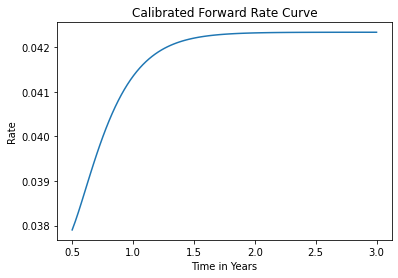

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def func(t, a, b, c, d):
    return a + b*np.exp(-t/d) + c*t/d*np.exp(-t/d)

# Define the values of a, b, c, and d
a = beta0
b = beta1
c = beta2
d = best_lambda

# Define the range of T values
T = np.linspace(0.5, 3, 100)

# Plot the function
plt.plot(T, func(T, a, b, c, d))
plt.xlabel('Time in Years')
plt.ylabel('Rate')
plt.title('Calibrated Forward Rate Curve')
plt.savefig("Forward Rate Curve.png")
plt.show()

In [26]:
def pricing(Num,sigma_x,sigma_s,sigma_r,cor_sr,a,ytm1,ytm2,S0,rf,r0,q,k,T):

    delta = 0.25  # 0.25 years
    Ty = 252  # 252 days in a year
    dt = 1 / Ty  # 1 day
    price = 0  # price of the contract
    e_Sr=0 # expected Nikkei ratio
    e_L=0 # expected Linor rate
    L0= 0.052 # current 3m-libor ratio
    
    stockpaths=np.zeros((Num,T*Ty+1))
    stockpaths[:,0] = S0
    srpaths=np.zeros((Num,T*Ty+1))
    srpaths[:,0] = r0
    payoffhist=np.zeros(Num)
    pricehist=np.zeros(Num)
    Liborhist=np.zeros(Num)
    

    for i in range(Num):
        W1 = normal(0, 1, (T*Ty, 1))
        W2 = normal(0, 1, (T*Ty, 1))
        W3 = cor_sr*W1 + np.sqrt(1 - cor_sr**2)*W2
        
        for j in range(T*Ty):
            stockpaths[i,j+1] = stockpaths[i,j] *(1+(rf - q - cor_sx*sigma_s*sigma_x)*dt + sigma_s*np.sqrt(dt)*W1[j]) 
            f = beta0 + beta1*np.exp(-j*dt/best_lambda) + beta2*j*dt/best_lambda*np.exp(-j*dt/best_lambda)
            df = 1/best_lambda*np.exp(-j*dt/best_lambda)*(-beta1 + beta2*(1-j*dt/best_lambda))
            theta = sigma_r**2/(2*a)*(1-np.exp(-2*a*j*dt)) + df + a*f
            srpaths[i,j+1] = srpaths[i,j] + (theta-a*srpaths[i,j])*dt + sigma_r*np.sqrt(dt)*W3[j]
               
        f_T_D = f
        r_T_D = srpaths[i,j]
        p_0_T = 1/(1+ytm1/100)**T
        p_0_T_D = 1/(1+ytm2/100)**(T-delta)
        B_T_D = 1/a*(1-np.exp(-a*delta))
        p_T_D_T = p_0_T/p_0_T_D*np.exp(B_T_D*f_T_D-sigma_r**2/(4*a)*B_T_D**2*(1-np.exp(-2*a*(T-delta)))-B_T_D*r_T_D)
        L = (abs(1-p_T_D_T))/(delta*p_T_D_T)
        Liborhist[i]=L
        
        payoff = max(0, (stockpaths[i,T*Ty]/S0-k)*(k-L/L0))
        discount = np.exp(-(sum(srpaths[i,:])-srpaths[i,0])*dt)
        payoffhist[i]=payoff
        pricehist[i]=payoff*discount
        price += payoff*discount
        e_Sr += stockpaths[i,T*Ty]/S0
        e_L += L
        
    print("Average simulated Nikkei ratio is:",e_Sr/Num)
    print("Average simulated LIBOR rate is:",e_L/Num)
    print("The price of the contract is:", price/Num)
    return(stockpaths,srpaths,payoffhist,pricehist,Liborhist)

In [27]:
# set params based on processed data
Num=1000
cor_sx = -0.15204482047169965  # correlation of Nikkei-225 return and exchange rate
sigma_x = 0.08235696458645585  # Annual Volatility of exchange rate USD/JPY
sigma_s = 0.1960546321639455  # Annual Volatility of Nikkei-225 return
sigma_r = 0.0370693728164378  # Annual Volatility of interest rate
cor_sr = 0.1585817213425081  # correlation of Nikkei-225 return and interest rate
a = 0.03 # mean reversion parameter
ytm1 = 0.0373 # Yield to maturity
ytm2 = 0.042 #interpolated yield to maturity 
S0 = 211.85 #current Nikkei price 
rf = 0.003 #risk-free rate 
r0 = 0.0468 #current interest rate
q = 0.019 #current Nikkei-225 dividend
k=0.5 # strike price
T=3 # number of years
stockpaths,srpaths,payoffhist,pricehist,Liborhist=pricing(Num,sigma_x,sigma_s,sigma_r,cor_sr,a,ytm1,ytm2,S0,rf,r0,q,k,T)

Average simulated Nikkei ratio is: 0.9598090621980682
Average simulated LIBOR rate is: 0.05326892431438559
The price of the contract is: 0.03904978463615824


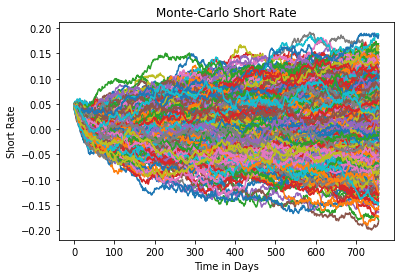

In [13]:
x_values = range(int(srpaths.size/len(srpaths)))

# Create a new figure and axis to plot on
fig, ax = plt.subplots()

# Plot the data as a line chart
for i in range(Num):
    ax.plot(x_values, srpaths[i])

# Set the x-axis and y-axis labels
ax.set_xlabel('Time in Days')
ax.set_ylabel('Short Rate')
# Set the title of the chart
ax.set_title('Monte-Carlo Short Rate')

# Show the chart
plt.savefig("'Monte-Carlo Short Rate.png")
plt.show()

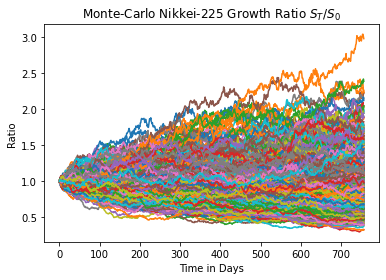

In [14]:
x_values = range(int(stockpaths.size/len(stockpaths)))

# Create a new figure and axis to plot on
fig, ax = plt.subplots()

# Plot the data as a line chart
for i in range(Num):
    ax.plot(x_values, stockpaths[i]/S0)

# Set the x-axis and y-axis labels
ax.set_xlabel('Time in Days')
ax.set_ylabel('Ratio')
# Set the title of the chart
ax.set_title('Monte-Carlo Nikkei-225 Growth Ratio $S_T/S_0$')

# Show the chart
plt.savefig("'Monte-Carlo Nikkei-225 Growth Ratio.png")
plt.show()

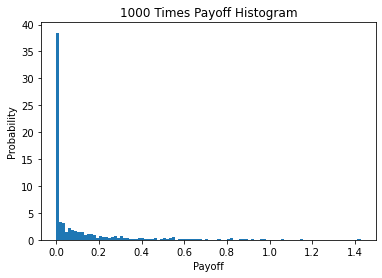

In [15]:
plt.hist(payoffhist, density=True, bins=100) 
plt.title("1000 Times Payoff Histogram")
plt.ylabel('Probability')
plt.xlabel('Payoff')
plt.savefig("'1000 Times Payoff Histogram.png")

Text(0.5, 0, 'Contract price')

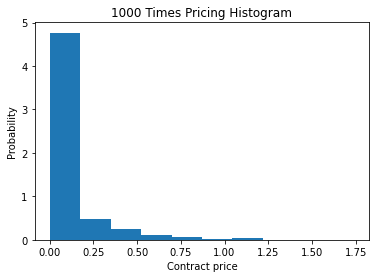

In [16]:
plt.hist(pricehist, density=True, bins=10)  
plt.title("1000 Times Pricing Histogram")
plt.ylabel('Probability')
plt.xlabel('Contract price')

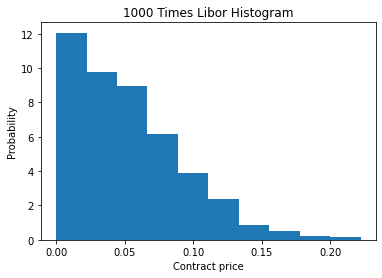

In [17]:
plt.hist(Liborhist, density=True, bins=10)  
plt.title("1000 Times Libor Histogram")
plt.ylabel('Probability')
plt.xlabel('Contract price')
plt.savefig("'1000 Times Libor Histogram.png")

In [28]:
def pricing(Num,sigma_x,sigma_s,sigma_r,cor_sr,a,ytm1,ytm2,S0,rf,r0,q,k,T):

    delta = 0.25  # 0.25 years
    Ty = 252  # 252 days in a year
    dt = 1 / Ty  # 1 day
    price = 0  # price of the contract
    e_Sr=0 # expected Nikkei ratio
    e_L=0 # expected Linor rate
    L0= 0.05 # current 3m-libor ratio
    
    stockpaths=np.zeros((Num,T*Ty+1))
    stockpaths[:,0] = S0
    srpaths=np.zeros((Num,T*Ty+1))
    srpaths[:,0] = r0
    payoffhist=np.zeros(Num)
    pricehist=np.zeros(Num)
    Liborhist=np.zeros(Num)
    

    for i in range(Num):
        W1 = normal(0, 1, (T*Ty, 1))
        W2 = normal(0, 1, (T*Ty, 1))
        W3 = cor_sr*W1 + np.sqrt(1 - cor_sr**2)*W2
        
        for j in range(T*Ty):
            stockpaths[i,j+1] = stockpaths[i,j] *(1+(rf - q - cor_sx*sigma_s*sigma_x)*dt + sigma_s*np.sqrt(dt)*W1[j]) 
            f = beta0 + beta1*np.exp(-j*dt/best_lambda) + beta2*j*dt/best_lambda*np.exp(-j*dt/best_lambda)
            df = 1/best_lambda*np.exp(-j*dt/best_lambda)*(-beta1 + beta2*(1-j*dt/best_lambda))
            theta = sigma_r**2/(2*a)*(1-np.exp(-2*a*j*dt)) + df + a*f
            srpaths[i,j+1] = srpaths[i,j] + (theta-a*srpaths[i,j])*dt + sigma_r*np.sqrt(dt)*W3[j]
               
        f_T_D = f
        r_T_D = srpaths[i,j]
        p_0_T = 1/(1+ytm1/100)**T
        p_0_T_D = 1/(1+ytm2/100)**(T-delta)
        B_T_D = 1/a*(1-np.exp(-a*delta))
        p_T_D_T = p_0_T/p_0_T_D*np.exp(B_T_D*f_T_D-sigma_r**2/(4*a)*B_T_D**2*(1-np.exp(-2*a*(T-delta)))-B_T_D*r_T_D)
        L = (abs(1-p_T_D_T))/(delta*p_T_D_T)
        Liborhist[i]=L
        
        payoff = max(0, (stockpaths[i,T*Ty]/S0-k)*(k-L/L0))
        discount = np.exp(-(sum(srpaths[i,:])-srpaths[i,0])*dt)
        payoffhist[i]=payoff
        pricehist[i]=payoff*discount
        price += payoff*discount
        e_Sr += stockpaths[i,T*Ty]/S0
        e_L += L
    return(price/Num)

In [64]:
pricehistavg=[]
Num=100
for i in range(100):
    priceavg=pricing(Num,sigma_x,sigma_s,sigma_r,cor_sr,a,ytm1,ytm2,S0,rf,r0,q,k,T)
    pricehistavg.append(priceavg)

In [18]:
plt.hist(pricehistavg, density=True, bins=10)  
price=np.mean(pricehistavg)
plt.title('Simulated Contract Price=%f' %price)
plt.ylabel('Probability')
plt.xlabel('Contract price')
plt.savefig("Simulated Contract Price.png")

NameError: name 'pricehistavg' is not defined

In [98]:
strikesensitivity=[]
Num=3000
T=3
for i in range(10):
    k=0.5+i*0.2
    pricesensitivity=pricing(Num,sigma_x,sigma_s,sigma_r,cor_sr,a,ytm1,ytm2,S0,rf,r0,q,k,T)
    strikesensitivity.append(pricesensitivity)

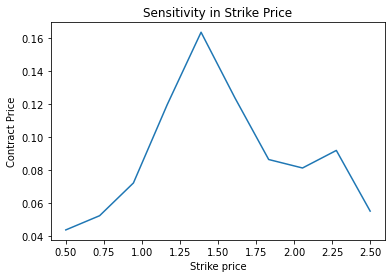

In [99]:
k=np.linspace(0.5,2.5,10)
plt.plot(k,strikesensitivity)  
price=np.mean(pricesensitivity)
plt.title('Sensitivity in Strike Price')
plt.ylabel('Contract Price')
plt.xlabel('Strike price')
plt.savefig("Sensitivity in Strike.png")

In [85]:
Num=3000
k=1
Timesensitivity=[]
Timesensitivity.append(pricing(Num,sigma_x,sigma_s,sigma_r,cor_sr,a,ytm1,ytm2,S0,rf,r0,q,k,1))
Timesensitivity.append(pricing(Num,sigma_x,sigma_s,sigma_r,cor_sr,a,ytm1,ytm2,S0,rf,r0,q,k,2))
Timesensitivity.append(pricing(Num,sigma_x,sigma_s,sigma_r,cor_sr,a,ytm1,ytm2,S0,rf,r0,q,k,3))
Timesensitivity.append(pricing(Num,sigma_x,sigma_s,sigma_r,cor_sr,a,ytm1,ytm2,S0,rf,r0,q,k,4))
Timesensitivity.append(pricing(Num,sigma_x,sigma_s,sigma_r,cor_sr,a,ytm1,ytm2,S0,rf,r0,q,k,5))

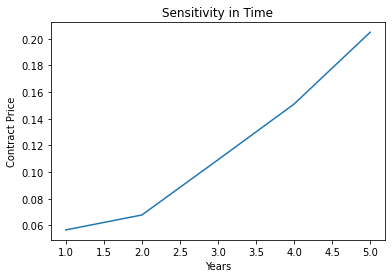

In [86]:
T=np.linspace(1,5,5)
plt.plot(T,Timesensitivity)  
price=np.mean(pricesensitivity)
plt.title('Sensitivity in Time')
plt.ylabel('Contract Price')
plt.xlabel('Years')
plt.savefig("Sensitivity in Time.png")